# Generating Random Variables

Author: Fred J. Hickernell + ChatGPT

This notebook provides examples of generating IID and low discrepancy samples from specific distributions and visualizing the results.

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/GeneratingRandomVectors.ipynb?flush_cache=true)

In [9]:
if "google.colab" in str(get_ipython()):
    print("⚡Note: Setup here can take a few minutes.")
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop
    !git clone https://github.com/QMCSoftware/MATH565Fall2025.git
    %cd MATH565Fall2025/notebooks
    print("\n✅ Colab setup complete.")
    print("   For faster performance, please install the qmcpy environment locally.")

### Import needed packages and initialize some parameters

In [10]:
import matplotlib.pyplot as plt
import math, time, timeit, sys
import numpy as np
import scipy as sp
from scipy import stats
import qmcpy as qp
import sympy as sy
from IPython.display import Markdown
import mc_class as init
init.init()                 # apply rcParams + numpy error policy
colors = init.get_py_colors()

## IID Binomial samples
We start with the distribution that describes how many free throws we successfully make out of three attempts if we are a 60% free throw shooter and attempt 
- Generate $N$ samples with `scipy.stats.binom.rvs`
- Show **side-by-side** histograms for $N = 10$ and $N = 1000$
- Overlay the true PMF for comparison

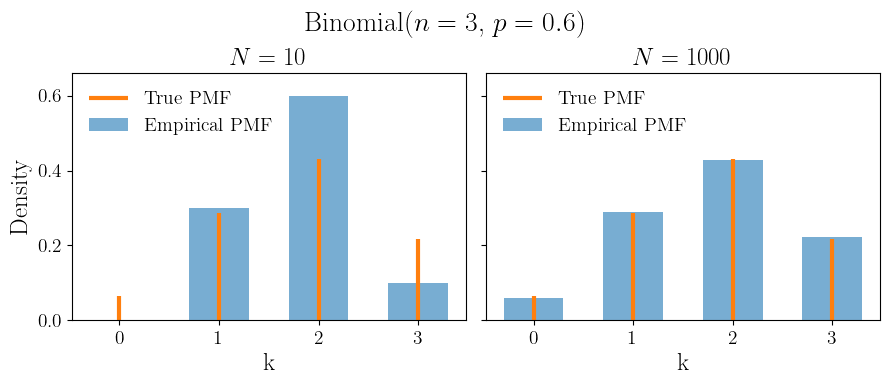

In [15]:
n, p = 3, 0.6  #the parameters of the Binomial distribution
free_throws_rv = stats.binom(n=n, p=p)  #set up a Binomial random variable
k = np.arange(n+1)  #possible numbers of successes
pmf = free_throws_rv.pmf(k)  #evaluate the true (population) values of the probability mass function

N_vals = np.array([10, 1000])  #different sample sizes
num_N = len(N_vals)
bins=np.arange(-0.25, n+1.25, 0.5)
fig, axes = plt.subplots(1, num_N, figsize=(4.5*num_N, 4), sharey=True)

ymax = 1.2*pmf.max()
for ax, N in zip(axes, N_vals):
    samples = free_throws_rv.rvs(size=N)
    freq = np.bincount(samples, minlength=n+1) / N   # empirical PMF
    ax.bar(k, freq, width=0.6, color=colors["blue"], alpha=0.6, label="Empirical PMF")
    ax.vlines(k, 0, pmf, colors=colors["orange"], lw=3, label="True PMF")
    ax.set_title(f"$N={N}$")
    ax.set_xlabel("k")
    ymax = max(ymax, 1.1 * freq.max())
    ax.legend(loc="upper left")

axes[0].set_ylim(0, ymax)
axes[0].set_ylabel("Density")
fig.suptitle(f"Binomial($n={n}$, $p={p}$)", y=0.95, fontsize = 20)
plt.tight_layout()

<div class="highlight-note">
Note:
<ul>
  <li>Every time you run the cell above you get a different answer</li>
  <li> Larger sample sizes tend to give better approximations to the true density</li>
</ul></div>

## Zero-Inflated Exponential (ZIE)
- Probability of zero wait: $p = 0.2$
- Positive waits are Exponential with **mean** 10 minutes (scale = 10)
- Generate IID samples; show **empirical CDF** using `statsmodels` for N = 10 and N = 1000

First we define the distribution via a stats class

In [17]:
class zero_inflated_expon(stats.rv_continuous):
    """
    Zero-inflated exponential:
    P(X=0) = p_zero;  for x>0, X|X>0 ~ Exponential(rate) with mean = 1/rate.

    Parameters
    ----------
    p_zero : float in [0,1)
        Probability of zero wait time (atom at 0).
    rate : float > 0
        Exponential rate for the positive part (1/mean of positive waits).
    """
    def __init__(self, p_zero=0.2, rate=0.1, *args, **kwargs):
        super().__init__(a=0.0, name="zero_inflated_expon", *args, **kwargs)
        if not (0.0 <= p_zero < 1.0):
            raise ValueError("p_zero must be in [0,1).")
        if rate <= 0:
            raise ValueError("rate must be > 0.")
        self.p_zero = float(p_zero)
        self.rate = float(rate)

    # Public CDF (right-continuous): F(0) = p_zero
    def cdf(self, x, *args, **kwargs):
        p0, lam = self.p_zero, self.rate
        x = np.asarray(x, dtype=float)
        # For x < 0: 0; for x >= 0: p0 + (1-p0)*(1 - e^{-lam x})
        return np.where(x < 0.0, 0.0, p0 + (1.0 - p0) * (1.0 - np.exp(-lam * x)))

    # Closed-form PPF (quantile)
    def _ppf(self, q):
        p0, lam = self.p_zero, self.rate
        q = np.asarray(q, dtype=float)
        out = np.zeros_like(q)
        mask = (q > p0) & (q < 1.0)
        t = (q[mask] - p0) / (1.0 - p0)
        out[mask] = -np.log1p(-t) / lam
        out = np.where(q >= 1.0, np.inf, out)
        out = np.where(q < 0.0, np.nan, out)
        return out

    # Vectorized RNG compatible with SciPy’s machinery
    def _rvs(self, size=None, random_state=None):
        p0, lam = self.p_zero, self.rate
        u = random_state.random(size)
        x = np.zeros(size, dtype=float)
        mask = u >= p0
        x[mask] = random_state.exponential(scale=1.0/lam, size=np.sum(mask))
        return x

# --- Convenience constructor ---
def make_zie(p_zero: float, mean_pos: float):
    """
    Convenience constructor: return a zero_inflated_expon
    with atom at 0 (prob = p_zero) and mean wait time = mean_pos for positive values.
    """
    return zero_inflated_expon(p_zero=p_zero, rate=1.0/mean_pos)

Next we set up the parameters and plot the empirical CDF for this distribution

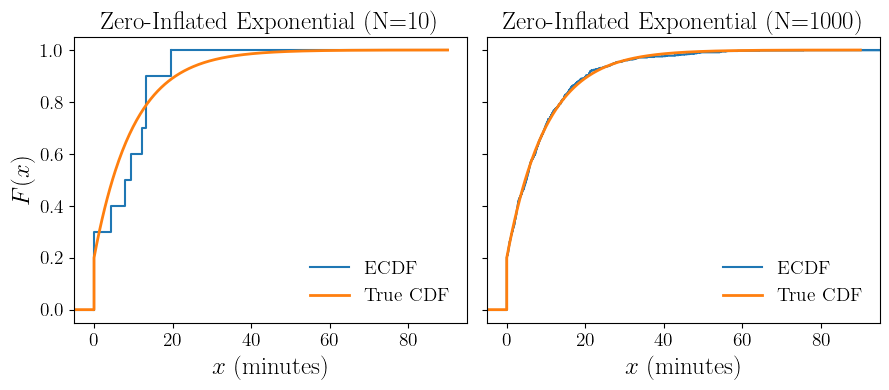

In [18]:
# --- ECDF plots with for-loops and statsmodels ---
from statsmodels.distributions.empirical_distribution import ECDF

# Parameters: p_zero = 0.2, positive mean = 10 minutes -> rate = 1/10
p_zero = 0.2        # P(X = 0) probability of a taxi already at the 'L' station
mean_pos = 10.0     # mean witing time in minutes if no taxi is there

zie = make_zie(p_zero=p_zero, mean_pos=mean_pos) #using the class defiend above

N_vals = [10, 1000]  #number of samples
m = len(N_vals)  #number of different N
xmax = 90  #maximum value of the random variable for plotting

fig, axes = plt.subplots(1, m, figsize=(4.5*m, 4), sharey=True)
axes = np.atleast_1d(axes)

for ax, N in zip(axes, N_vals):
    samples = zie.rvs(size=N)

    # statsmodels empirical cumulative distribution function
    ecdf = ECDF(samples)
    ax.step(ecdf.x, ecdf.y, where="post", label=f"ECDF", color=colors["blue"])
    ax.hlines(ecdf.y[-1], ecdf.x[-1], xmax, colors=colors["blue"], linestyles="solid")
    ax.hlines(0, -5, 0, colors=colors["blue"], linestyles="solid")

    # --- True CDF ---
    # Force grid to include 0 and a tiny epsilon so that we can see the vertical line
    grid = np.concatenate([[-5,-1e-9], np.linspace(0, xmax, 400)])
    ax.plot(grid, zie.cdf(grid), color=colors["orange"], lw=2, label="True CDF")

    ax.set_xlim(-5, xmax+5)
    ax.set_title(f"Zero-Inflated Exponential (N={N})")
    ax.set_xlabel("$x$ (minutes)")
    ax.legend(loc="lower right")

axes[0].set_ylabel("$F(x)$")
plt.tight_layout()

<div class="highlight-note">
Note:
<ul>
  <li> Again, larger sample sizes give better approximations</li>
  <li> $F(x)$ is discontinuous at $x=0$</li>
</ul></div>

## Multivariate Gaussian/Normal Random Variable

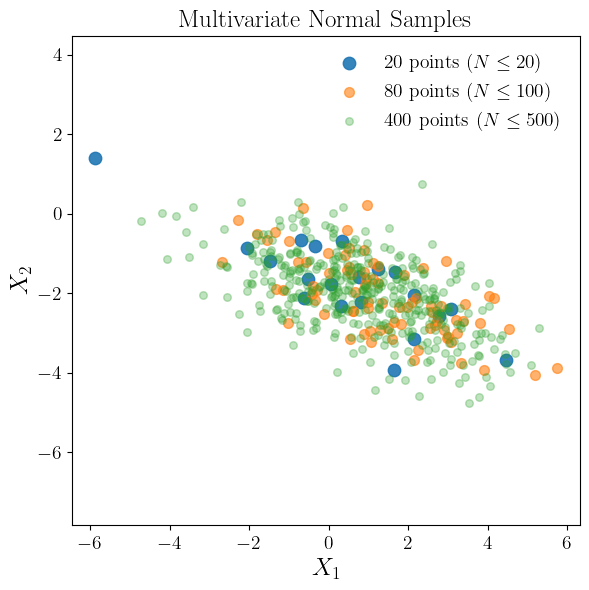

In [19]:
# Parameters
mu = np.array([1.0, -2.0])
Sigma = np.array([[3.0, -1.0],
                  [-1.0,  1.0]])
mvn = stats.multivariate_normal(mean=mu, cov=Sigma)  #Set up multivariate normal
N_max = max(N_vals)
mvn_samples = mvn.rvs(size=N_max);

N_vals = [20, 100, 500]
colors_list = [colors["blue"], colors["orange"], colors["green"]]
alpha_list = [0.9, 0.6, 0.3]
size_list = [80, 50, 30]

fig, ax = plt.subplots(figsize=(6, 6))
prevN = 0
for i, N in enumerate(N_vals):
    ax.scatter(mvn_samples[prevN:N, 0], mvn_samples[prevN:N, 1], s=size_list[i], alpha=alpha_list[i], \
               color=colors_list[i], label=f"{N - prevN} points ($N \\le {N}$)")
    prevN = N
ax.set_title("Multivariate Normal Samples")
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")
ax.axis("equal")
ax.legend(loc="upper right")
plt.tight_layout()